**XLnet vs Bert in text classification**

#packages

In [ ]:
!pip install -q transformers accelerate

     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 143 kB 73.7 MB/s 
     |████████████████████████████████| 6.6 MB 42.8 MB/s 
     |████████████████████████████████| 101 kB 11.7 MB/s 


#data

In [ ]:
!gdown --id  1wHt8PsMLsfX5yNSqrt2fSTcb8LEiclcf                                                             

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1wHt8PsMLsfX5yNSqrt2fSTcb8LEiclcf
To: /content/data.zip
100% 491k/491k [00:00<00:00, 132MB/s]


In [ ]:
!unzip /content/data.zip

Archive:  /content/data.zip
  inflating: complaint1700.csv       
  inflating: noncomplaint1700.csv    
  inflating: test_data.csv           


In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
pos = pd.read_csv('/content/complaint1700.csv')
pos['label'] = 0
neg = pd.read_csv('/content/noncomplaint1700.csv')
neg['label'] = 1
train_df = pd.concat([pos, neg]).reset_index(drop=True)



train_df = train_df.loc[:, ['tweet', 'label']]
test_df = pd.read_csv('/content/test_data.csv').loc[:, ['tweet']]

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
train_df['tweet'] = train_df['tweet'].apply(text_preprocessing)
test_df['tweet'] = test_df['tweet'].apply(text_preprocessing)

In [ ]:
#train val
concat_df = train_df
train_df, val_df = train_test_split(concat_df, test_size=0.2, random_state=3)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [ ]:
#vocab 

class Vocab:
    def __init__(self, name=None):
        self.name = name
        self.word2idx = {"[PAD]": 0, "[SOS]": 1, "[EOS]": 2}
        self.idx2word = {1: "[SOS]", 0: "[PAD]", 2: "[EOS]"} #3 special keywords
        self.num_words = 3
        self.word_counts = {} #SOS, EOS, PAD

    def add_sentence(self, sentence):
        for word in sentence.split():
            self.add_word(word)
    def add_word(self, word):
        if word in self.word2idx.keys():
            self.word_counts[word] += 1

        else:
            self.word2idx[word] = self.num_words
            self.idx2word[self.num_words] = word
            self.word_counts[word] = 1 
            self.num_words += 1


In [ ]:
vocab = Vocab()
sentences = []
sentences.extend(concat_df['tweet'])
sentences.extend(test_df['tweet'])
for sentence in sentences:
  if "EOS" in sentence:
    print(sentence)
    break
    vocab.add_sentence(sentence)

vocab.num_words

3

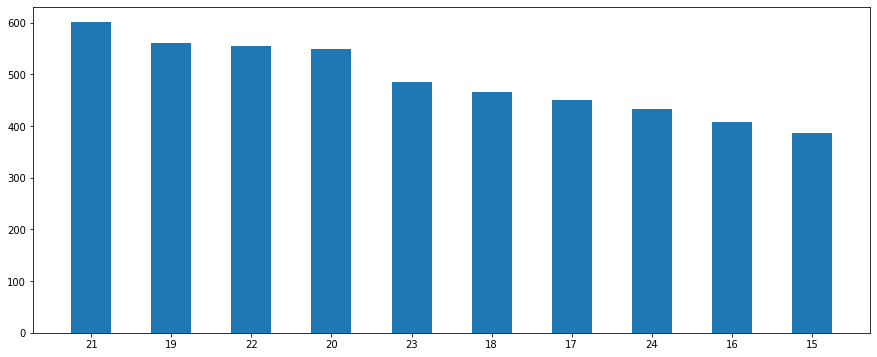

In [ ]:
#get the MAXLEN
length = {}
for sentence in sentences:
  if len(sentence.split()) in length:
    length[len(sentence.split())] += 1 
  else:
    length[len(sentence.split())] = 1

list_dict = sorted([(i, j) for i, j in length.items()], key=lambda x: x[1], reverse=True)[:10]
label = [list_dict[i][0] for i in range(len(list_dict))]
fig, ax = plt.subplots(figsize=(15,6))
pos = np.arange(10)
ax.bar(pos, [i[1] for i in list_dict], width=0.5)
ax.set_xticks(pos)
ax.set_xticklabels(label)
plt.show()


In [ ]:
MAXLEN = 24

In [ ]:
# Create a function to tokenize a set of texts
def preprocessing_for_pretrained(data, tokenizer):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        token = tokenizer(
            text=text_preprocessing(sent),  # Preprocess sentence
            max_length=MAXLEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            # return_tensors='pt',           # Return PyTorch tensor, but we use list for concat later 
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(token['input_ids'])
        attention_masks.append(token['attention_mask'])

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# preprocessing_for_pretrained(val_df, xlnet_tokenizer)

#models

In [ ]:
import pandas as pd
import re
import warnings
from tqdm.auto import tqdm
from time import sleep
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, BertModel, AdamW, AutoModel, BertConfig
from accelerate import Accelerator

from google.colab import output
output.enable_custom_widget_manager()

warnings.filterwarnings("ignore")

In [ ]:
'''xlnet vs bert, M and pretrained R 
  config is M = untrained R .from_config
  pretrained is M = trained R .from_pretrained
  model.config -> check the config if u wanna  
''' 
#XLNET, config example 
# xlnet_config = XLNetConfig()
# xlnet = AutoModel.from_config(xlnet_config) from scratch
xlnet_tokenizer = AutoTokenizer.from_pretrained('xlnet-base-cased')
xlnet = AutoModel.from_pretrained('xlnet-base-cased')
#BERT
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = AutoModel.from_pretrained("bert-base-uncased")



Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expecte

In [ ]:
'''
info: 
input_ids: tokenize, special <sep> <cls> for xlnet, <cls> for bert
attention_mask:
token_type: different for pairs, and token type for <cls> in xlnet is 2 

'''
sentence = "my name is good boy"
sub = "you too"
bert_token = tokenizer(sentence, sub, return_tensors='pt')
xlnet_token = xlnet_tokenizer(sentence, return_tensors='pt')

input_ids, attention_masks = bert_token['input_ids'], bert_token['attention_mask']
input_ids, attention_masks = xlnet_token['input_ids'], xlnet_token['attention_mask']
# bert(input_ids, attention_masks)['pooler_output'].shape
# [xlnet_tokenizer.convert_ids_to_tokens(i) for i in input_ids], input_ids, attention_masks

In [ ]:
xlnet(input_ids, attention_masks)['last_hidden_state'].shape

torch.Size([1, 7, 768])

In [ ]:
class Xlnet_classifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super().__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.xlnet = AutoModel.from_pretrained('xlnet-base-cased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the Xlnet model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.xlnet(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs['last_hidden_state'][:, -1, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [ ]:
class Bert_classifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super().__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs['pooler_output']

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

#train

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
X_train = train_df['tweet']
X_val = val_df['tweet']
X_test = test_df['tweet']
MAX_LEN = 24

In [ ]:
tokenizer = xlnet_tokenizer

In [ ]:
X_train_input, X_train_attention = preprocessing_for_pretrained(X_train, tokenizer)
X_val_input, X_val_attention = preprocessing_for_pretrained(X_val, tokenizer) 
X_test_input, X_test_attention = preprocessing_for_pretrained(X_test, tokenizer)
y_train = torch.tensor(train_df['label'].values, dtype=torch.long)
y_val = torch.tensor(val_df['label'].values, dtype=torch.long)

In [ ]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
epochs = 10
# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(X_train_input, X_train_attention, y_train)
train_dataloader = DataLoader(train_data,  batch_size=batch_size, shuffle=True)

# Create the DataLoader for our validation set
val_data = TensorDataset(X_val_input, X_val_attention, y_val)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
model = Xlnet_classifier()
optimizer = AdamW(model.parameters(), lr=5e-6)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
accelerator = Accelerator()
model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader
)
accelerator.device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    run = tqdm(range(total_steps))
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            optimizer.zero_grad()
            # print(b_input_ids.shape, b_attn_mask.shape)
            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()
            run.update(1)


            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            with torch.no_grad():
              model.eval()
              # After the completion of each training epoch, measure the model's performance
              # on our validation set.
              val_loss, val_accuracy = evaluate(model, val_dataloader)

              # Print performance over the entire training data
              time_elapsed = time.time() - t0_epoch
              
              print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
              print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        prob = nn.functional.softmax(logits, dim=1)
  

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
set_seed(3)
train(model, train_dataloader, val_dataloader, epochs=15, evaluation=True)

#evaluation

In [ ]:
import torch.nn.functional as F

def predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [ ]:
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    print(threshold)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # # Get accuracy over the test set
    # y_pred = np.where(preds >= 0.5, 1, 0)
    # accuracy = accuracy_score(y_true, y_pred)
    # print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [ ]:
probs = predict(model, val_dataloader)
probs.shape #prob for 2 classes

(680, 2)

[1.99409628e+00 9.94096279e-01 9.92628694e-01 9.92562473e-01
 9.86936510e-01 9.86666858e-01 9.83056486e-01 9.82909560e-01
 9.78563249e-01 9.78093266e-01 9.76193130e-01 9.75632370e-01
 9.60691988e-01 9.59332228e-01 9.58157241e-01 9.58072603e-01
 9.55093920e-01 9.54745114e-01 9.54149842e-01 9.46132123e-01
 9.44670618e-01 9.40278172e-01 9.40025210e-01 9.36607718e-01
 9.33917224e-01 9.30116355e-01 9.29498851e-01 9.23274517e-01
 9.22860384e-01 9.15024638e-01 9.13902521e-01 9.13099051e-01
 9.10724938e-01 9.03326809e-01 9.03264940e-01 8.97718549e-01
 8.97458494e-01 8.89981151e-01 8.89216721e-01 8.89095485e-01
 8.88481438e-01 8.74667048e-01 8.71894598e-01 8.69242489e-01
 8.67363513e-01 8.67310286e-01 8.66024613e-01 8.62882793e-01
 8.59091818e-01 8.38558257e-01 8.35290372e-01 8.34790349e-01
 8.34255874e-01 8.34236443e-01 8.29466045e-01 8.23168278e-01
 8.18165720e-01 8.15200925e-01 8.12802851e-01 8.10909092e-01
 8.05890441e-01 7.99788952e-01 7.98482776e-01 7.97590137e-01
 7.86563456e-01 7.838386

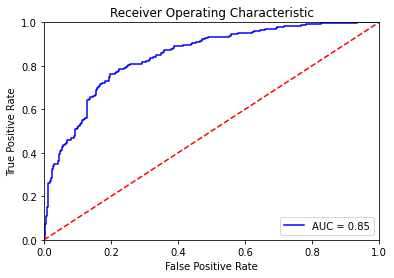

In [ ]:
evaluate_roc(probs, y_val)